**Team: Spatial Extent**

*Challenge 2*

Notebook 1

VGG-based models, no tiles

In [1]:
import os
import tensorflow as tf
import numpy as np
from PIL import Image
import json
import pandas as pd

In [2]:
SEED = 1234
tf.random.set_seed(SEED)  
np.random.seed(SEED)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/_Polimi/NN/Development_Dataset.zip

Archive:  /content/drive/MyDrive/_Polimi/NN/Development_Dataset.zip
  inflating: Development_Dataset/LICENSE.txt  
   creating: Development_Dataset/Test_Dev/
   creating: Development_Dataset/Test_Dev/Bipbip/
   creating: Development_Dataset/Test_Dev/Bipbip/Haricot/
   creating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00211.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00581.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00721.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00951.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_01341.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02421.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02781.jpg  
  inflating

# Test to highlight green

In [5]:
import matplotlib.pyplot as plt

def highligt_background(RGBim):
  #fig, ax = plt.subplots(1,3)
  # Open image and make RGB and HSV versions
  #RGBim = Image.open("Development_Dataset/Training/Bipbip/Mais/Images/Bipbip_mais_im_05031.jpg").convert('RGB')
  #RGBim = Image.open("Development_Dataset/Training/Roseau/Haricot/Images/Roseau_haricot_0312_false.png").convert('RGB')
  #RGBmask = Image.open("Development_Dataset/Training/Roseau/Haricot/Masks/Roseau_haricot_0312_false.png").convert('RGB')
  #ax[0].imshow(RGBim)
  #ax[2].imshow(RGBmask)

  HSVim = RGBim.convert('HSV')
  # Make numpy versions
  RGBna = np.array(RGBim)
  HSVna = np.array(HSVim)

  # Extract Hue
  H = HSVna[:,:,0]

  # Find all green pixels, i.e. where 100 < Hue < 140
  lo,hi = 70,150
  # Rescale to 0-255, rather than 0-360 because we are using uint8
  lo = int((lo * 255) / 360)
  hi = int((hi * 255) / 360)
  #green = np.where((H>lo) & (H<hi))
  not_green = np.where((H<lo) | (H>hi))

  # Make all not green pixels black in original image
  RGBna[not_green] = [0,0,0]

  #count = not_green[0].size
  #print("Pixels matched: {}".format(count))
  #Image.fromarray(RGBna).save('result.png')
  #ax[1].imshow(Image.fromarray(RGBna))
  return Image.fromarray(RGBna)

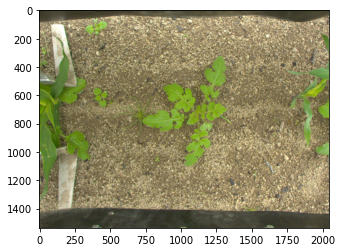

In [6]:
RGBim = Image.open("Development_Dataset/Training/Roseau/Mais/Images/Roseau_mais_0010_false.png").convert('RGB')
RGBim = Image.open("Development_Dataset/Training/Bipbip/Mais/Images/Bipbip_mais_im_05031.jpg").convert('RGB')
plt.imshow(RGBim)


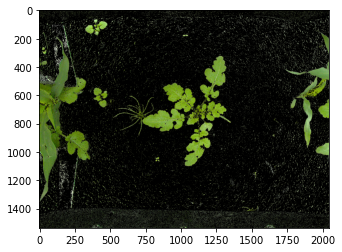

In [8]:
highlighted = highligt_background(RGBim)
plt.imshow(highlighted)

# Prepare dataset

In [ ]:
dataset_dir = '/content/Development_Dataset/Training'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_img_data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=10,
                                  height_shift_range=10,
                                  zoom_range=0.3,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='reflect'
                                  #rescale=1./255,
                                  #preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
                                  #validation_split=0.2
                                  )
train_mask_data_gen = ImageDataGenerator(rotation_range=10,
                                    width_shift_range=10,
                                    height_shift_range=10,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='reflect'
                                    #validation_split=0.2
                                    )
valid_img_data_gen = ImageDataGenerator(
                                      #rescale=1./255,
                                      #preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
                                      #validation_split=0.2
                                      )
valid_mask_data_gen = ImageDataGenerator(
                                      #validation_split=0.2
                                      )

The following cells selects among the teams and crop types, loading the images and masks filename in the corresponding dataframes

In [ ]:
def files_for_team(team, mais=True, haricot=True):
  team_folder = os.path.join(dataset_dir,team)
  haricot_images = []
  haricot_masks = []
  mais_images =  []
  mais_masks = []
  if haricot:
    haricot_images = os.listdir(os.path.join(team_folder,'Haricot/Images'))
    haricot_images = [os.path.join(team_folder,'Haricot/Images',i) for i in haricot_images]

    haricot_masks = os.listdir(os.path.join(team_folder,'Haricot/Masks'))
    haricot_masks = [os.path.join(team_folder,'Haricot/Masks',i) for i in haricot_masks]

  if mais:
    mais_images = os.listdir(os.path.join(team_folder,'Mais/Images'))
    mais_images = [os.path.join(team_folder,'Mais/Images',i) for i in mais_images]

    mais_masks = os.listdir(os.path.join(team_folder,'Mais/Masks'))
    mais_masks = [os.path.join(team_folder,'Mais/Masks',i) for i in mais_masks]

  #sort to be sure that images and masks are paired
  images = sorted(haricot_images + mais_images)
  masks = sorted(haricot_masks + mais_masks)
  return images, masks 

TEAMS:
*   Bipbip
*   Roseau
*   Weedelec
*   Pead (different)

In [ ]:
bipbip_haricot=True
bipbip_mais=True
roseau_haricot=True
roseau_mais = True
weedelec_haricot = True
weedelec_mais = True
pead_haricot = True
pead_mais = True
images, masks = files_for_team('Bipbip',mais=bipbip_mais, haricot=bipbip_haricot)
imagesR, masksR = files_for_team('Roseau',mais=roseau_mais, haricot=roseau_haricot)
imagesW, masksW = files_for_team('Weedelec',mais=weedelec_mais, haricot=weedelec_haricot)
imagesP, masksP = files_for_team('Pead',mais=pead_mais, haricot=pead_haricot)
images += imagesR
images += imagesW
images += imagesP
masks += masksR
masks += masksW 
masks += masksP
print(masks)
print(images)

['/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_00321.png', '/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_00391.png', '/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_00451.png', '/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_00511.png', '/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_00651.png', '/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_00801.png', '/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_00871.png', '/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_01021.png', '/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_01091.png', '/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_01271.png', '/content/Development_Dataset/Training/Bipbip/Haricot/Masks/Bipbip_haricot_im_01451.png', '/content

In [ ]:
d = {'Images':images,'Masks':masks}
df = pd.DataFrame(d)
df = df.sample(frac = 1) #shuffle together images and masks

images_dataframe = df[['Images']]
masks_dataframe = df[['Masks']]
images_dataframe.head()
masks_dataframe.head()

,Masks
146,/content/Development_Dataset/Training/Bipbip/M...
131,/content/Development_Dataset/Training/Bipbip/M...
650,/content/Development_Dataset/Training/Pead/Mai...
613,/content/Development_Dataset/Training/Pead/Har...
355,/content/Development_Dataset/Training/Roseau/M...


The following functions create a text file used later on by the CustomDataset to load training and validation images

In [ ]:
import math
def create_csv(val_split=0.15):
  train = 'train.txt'
  valid = 'valid.txt'
  t = open(train, 'w')
  v = open(valid, 'w')
  num_elems =  images_dataframe.shape[0]
  train_elems = math.ceil(num_elems * (1 - val_split))
  valid_elems = math.floor(num_elems * val_split)
  count = 0
  print(num_elems)
  for filename in images_dataframe['Images']:
    #print(filename)
    if (count <= train_elems):
      t.write(filename + '\n')
    else:
      v.write(filename + '\n')
    count +=1

In [ ]:
create_csv()

720


In [ ]:
# Batch size
bs = 4


img_h = 1536 #1536
img_w = 2048 #2048

In [ ]:
def read_rgb_mask(img_path, resize_shape):
    '''
    img_path: path to the mask file
    Returns the numpy array containing target values
    '''

    mask_img = Image.open(img_path)
    mask_img = mask_img.resize(resize_shape, resample=Image.NEAREST)

    mask_arr = np.array(mask_img)
   
    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)
    
    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [254, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr

In [ ]:
class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[img_w, img_h]):
    if which_subset == 'training':
      subset_file = 'train.txt'
    elif which_subset == 'validation':
      subset_file = 'valid.txt'
    
    with open(subset_file, 'r') as f:
      lines = f.readlines()
    
    subset_filenames = []
    for line in lines:
      subset_filenames.append(line.strip()) 

    self.which_subset = which_subset
    #self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(curr_filename)
    #mask = Image.open(curr_filename)
    mask_file = curr_filename.replace("jpg", "png")
    mask_file = mask_file.replace("Images", "Masks")
    mask_arr = read_rgb_mask(mask_file, self.out_shape)



    # Resize image and mask
    #if self.which_subset == 'training':
    img = img.resize(self.out_shape) #this has been removed later on


    ###HIGHLIGHTING PREPROCESSING
    #img = highligt_background(img)
    ###
    
    #mask = mask.resize(self.out_shape, resample=Image.NEAREST)
    
    img_arr = np.array(img)
    #mask_arr = np.array(mask)

    # in this dataset 255 mask label is assigned to an additional class, which corresponds 
    # to the contours of the objects. We remove it for simplicity.
    #mask_arr[mask_arr == 255] = 0  

    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)
    else
        img_arr = img_arr / 255.0 #normalize

    return img_arr, np.float32(out_mask)

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input 


dataset = CustomDataset('training', 
                        img_generator=train_img_data_gen, mask_generator=train_mask_data_gen,
                        preprocessing_function=preprocess_input)
dataset_valid = CustomDataset('validation', 
                              preprocessing_function=preprocess_input)

In [ ]:
train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, None, 3], [None, None, 1]))

train_dataset = train_dataset.batch(bs)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               #output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
                                               output_shapes=([None, None, 3], [None, None, 1]))
valid_dataset = valid_dataset.batch(bs)

valid_dataset = valid_dataset.repeat()

Let's check if what we loaded seems to be correct

In [ ]:
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

iterator = iter(valid_dataset)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1536, 2048)


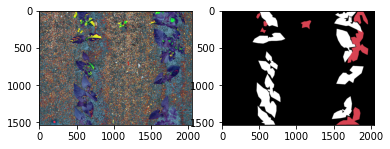

In [ ]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img*255  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

#print(np.unique(target))
print(target)
print(target.shape)
target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
target_img[np.where(target == 1)] = [255,255,255]
target_img[np.where(target == 2)] = [216,67,82]

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

# Sparse focal loss

This is an alternative to the SparseCategoricalCrossEntropy. We tried it with different weights, more or less balanced, but it never provided a useful improvement. It is taken from https://github.com/artemmavrin/focal-loss/blob/master/src/focal_loss/_categorical_focal_loss.py

In [ ]:
"""Multiclass focal loss implementation."""
#    __                          _     _
#   / _|                        | |   | |
#  | |_    ___     ___    __ _  | |   | |   ___    ___   ___
#  |  _|  / _ \   / __|  / _` | | |   | |  / _ \  / __| / __|
#  | |   | (_) | | (__  | (_| | | |   | | | (_) | \__ \ \__ \
#  |_|    \___/   \___|  \__,_| |_|   |_|  \___/  |___/ |___/

import itertools
from typing import Any, Optional

import tensorflow as tf

_EPSILON = tf.keras.backend.epsilon()


def sparse_categorical_focal_loss(y_true, y_pred, gamma, *,
                                  class_weight: Optional[Any] = None,
                                  from_logits: bool = False, axis: int = -1
                                  ) -> tf.Tensor:
    r"""Focal loss function for multiclass classification with integer labels.
    This loss function generalizes multiclass softmax cross-entropy by
    introducing a hyperparameter called the *focusing parameter* that allows
    hard-to-classify examples to be penalized more heavily relative to
    easy-to-classify examples.
    See :meth:`~focal_loss.binary_focal_loss` for a description of the focal
    loss in the binary setting, as presented in the original work [1]_.
    In the multiclass setting, with integer labels :math:`y`, focal loss is
    defined as
    .. math::
        L(y, \hat{\mathbf{p}})
        = -\left(1 - \hat{p}_y\right)^\gamma \log(\hat{p}_y)
    where
    *   :math:`y \in \{0, \ldots, K - 1\}` is an integer class label (:math:`K`
        denotes the number of classes),
    *   :math:`\hat{\mathbf{p}} = (\hat{p}_0, \ldots, \hat{p}_{K-1})
        \in [0, 1]^K` is a vector representing an estimated probability
        distribution over the :math:`K` classes,
    *   :math:`\gamma` (gamma, not :math:`y`) is the *focusing parameter* that
        specifies how much higher-confidence correct predictions contribute to
        the overall loss (the higher the :math:`\gamma`, the higher the rate at
        which easy-to-classify examples are down-weighted).
    The usual multiclass softmax cross-entropy loss is recovered by setting
    :math:`\gamma = 0`.
    Parameters
    ----------
    y_true : tensor-like
        Integer class labels.
    y_pred : tensor-like
        Either probabilities or logits, depending on the `from_logits`
        parameter.
    gamma : float or tensor-like of shape (K,)
        The focusing parameter :math:`\gamma`. Higher values of `gamma` make
        easy-to-classify examples contribute less to the loss relative to
        hard-to-classify examples. Must be non-negative. This can be a
        one-dimensional tensor, in which case it specifies a focusing parameter
        for each class.
    class_weight: tensor-like of shape (K,)
        Weighting factor for each of the :math:`k` classes. If not specified,
        then all classes are weighted equally.
    from_logits : bool, optional
        Whether `y_pred` contains logits or probabilities.
    axis : int, optional
        Channel axis in the `y_pred` tensor.
    Returns
    -------
    :class:`tf.Tensor`
        The focal loss for each example.
    Examples
    --------
    This function computes the per-example focal loss between a one-dimensional
    integer label vector and a two-dimensional prediction matrix:
    >>> import numpy as np
    >>> from focal_loss import sparse_categorical_focal_loss
    >>> y_true = [0, 1, 2]
    >>> y_pred = [[0.8, 0.1, 0.1], [0.2, 0.7, 0.1], [0.2, 0.2, 0.6]]
    >>> loss = sparse_categorical_focal_loss(y_true, y_pred, gamma=2)
    >>> np.set_printoptions(precision=3)
    >>> print(loss.numpy())
    [0.009 0.032 0.082]
    Warnings
    --------
    This function does not reduce its output to a scalar, so it cannot be passed
    to :meth:`tf.keras.Model.compile` as a `loss` argument. Instead, use the
    wrapper class :class:`~focal_loss.SparseCategoricalFocalLoss`.
    References
    ----------
    .. [1] T. Lin, P. Goyal, R. Girshick, K. He and P. Dollár. Focal loss for
        dense object detection. IEEE Transactions on Pattern Analysis and
        Machine Intelligence, 2018.
        (`DOI <https://doi.org/10.1109/TPAMI.2018.2858826>`__)
        (`arXiv preprint <https://arxiv.org/abs/1708.02002>`__)
    See Also
    --------
    :meth:`~focal_loss.SparseCategoricalFocalLoss`
        A wrapper around this function that makes it a
        :class:`tf.keras.losses.Loss`.
    """
    # Process focusing parameter
    gamma = tf.convert_to_tensor(gamma, dtype=tf.dtypes.float32)
    gamma_rank = gamma.shape.rank
    scalar_gamma = gamma_rank == 0

    # Process class weight
    if class_weight is not None:
        class_weight = tf.convert_to_tensor(class_weight,
                                            dtype=tf.dtypes.float32)

    # Process prediction tensor
    y_pred = tf.convert_to_tensor(y_pred)
    y_pred_rank = y_pred.shape.rank
    if y_pred_rank is not None:
        axis %= y_pred_rank
        if axis != y_pred_rank - 1:
            # Put channel axis last for sparse_softmax_cross_entropy_with_logits
            perm = list(itertools.chain(range(axis),
                                        range(axis + 1, y_pred_rank), [axis]))
            y_pred = tf.transpose(y_pred, perm=perm)
    elif axis != -1:
        raise ValueError(
            f'Cannot compute sparse categorical focal loss with axis={axis} on '
            'a prediction tensor with statically unknown rank.')
    y_pred_shape = tf.shape(y_pred)

    # Process ground truth tensor
    y_true = tf.dtypes.cast(y_true, dtype=tf.dtypes.int64)
    y_true_rank = y_true.shape.rank

    if y_true_rank is None:
        raise NotImplementedError('Sparse categorical focal loss not supported '
                                  'for target/label tensors of unknown rank')

    reshape_needed = (y_true_rank is not None and y_pred_rank is not None and
                      y_pred_rank != y_true_rank + 1)
    if reshape_needed:
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1, y_pred_shape[-1]])

    if from_logits:
        logits = y_pred
        probs = tf.nn.softmax(y_pred, axis=-1)
    else:
        probs = y_pred
        logits = tf.math.log(tf.clip_by_value(y_pred, _EPSILON, 1 - _EPSILON))

    xent_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=y_true,
        logits=logits,
    )

    y_true_rank = y_true.shape.rank
    probs = tf.gather(probs, y_true, axis=-1, batch_dims=y_true_rank)
    if not scalar_gamma:
        gamma = tf.gather(gamma, y_true, axis=0, batch_dims=y_true_rank)
    focal_modulation = (1 - probs) ** gamma
    loss = focal_modulation * xent_loss

    if class_weight is not None:
        class_weight = tf.gather(class_weight, y_true, axis=0,
                                 batch_dims=y_true_rank)
        loss *= class_weight

    if reshape_needed:
        loss = tf.reshape(loss, y_pred_shape[:-1])

    return loss


@tf.keras.utils.register_keras_serializable()
class SparseCategoricalFocalLoss(tf.keras.losses.Loss):
    r"""Focal loss function for multiclass classification with integer labels.
    This loss function generalizes multiclass softmax cross-entropy by
    introducing a hyperparameter :math:`\gamma` (gamma), called the
    *focusing parameter*, that allows hard-to-classify examples to be penalized
    more heavily relative to easy-to-classify examples.
    This class is a wrapper around
    :class:`~focal_loss.sparse_categorical_focal_loss`. See the documentation
    there for details about this loss function.
    Parameters
    ----------
    gamma : float or tensor-like of shape (K,)
        The focusing parameter :math:`\gamma`. Higher values of `gamma` make
        easy-to-classify examples contribute less to the loss relative to
        hard-to-classify examples. Must be non-negative. This can be a
        one-dimensional tensor, in which case it specifies a focusing parameter
        for each class.
    class_weight: tensor-like of shape (K,)
        Weighting factor for each of the :math:`k` classes. If not specified,
        then all classes are weighted equally.
    from_logits : bool, optional
        Whether model prediction will be logits or probabilities.
    **kwargs : keyword arguments
        Other keyword arguments for :class:`tf.keras.losses.Loss` (e.g., `name`
        or `reduction`).
    Examples
    --------
    An instance of this class is a callable that takes a rank-one tensor of
    integer class labels `y_true` and a tensor of model predictions `y_pred` and
    returns a scalar tensor obtained by reducing the per-example focal loss (the
    default reduction is a batch-wise average).
    >>> from focal_loss import SparseCategoricalFocalLoss
    >>> loss_func = SparseCategoricalFocalLoss(gamma=2)
    >>> y_true = [0, 1, 2]
    >>> y_pred = [[0.8, 0.1, 0.1], [0.2, 0.7, 0.1], [0.2, 0.2, 0.6]]
    >>> loss_func(y_true, y_pred)
    <tf.Tensor: shape=(), dtype=float32, numpy=0.040919524>
    Use this class in the :mod:`tf.keras` API like any other multiclass
    classification loss function class that accepts integer labels found in
    :mod:`tf.keras.losses` (e.g.,
    :class:`tf.keras.losses.SparseCategoricalCrossentropy`:
    .. code-block:: python
        # Typical usage
        model = tf.keras.Model(...)
        model.compile(
            optimizer=...,
            loss=SparseCategoricalFocalLoss(gamma=2),  # Used here like a tf.keras loss
            metrics=...,
        )
        history = model.fit(...)
    See Also
    --------
    :meth:`~focal_loss.sparse_categorical_focal_loss`
        The function that performs the focal loss computation, taking a label
        tensor and a prediction tensor and outputting a loss.
    """

    def __init__(self, gamma, class_weight: Optional[Any] = None,
                 from_logits: bool = False, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.class_weight = class_weight
        self.from_logits = from_logits

    def get_config(self):
        """Returns the config of the layer.
        A layer config is a Python dictionary containing the configuration of a
        layer. The same layer can be re-instantiated later (without its trained
        weights) from this configuration.
        Returns
        -------
        dict
            This layer's config.
        """
        config = super().get_config()
        config.update(gamma=self.gamma, class_weight=self.class_weight,
                      from_logits=self.from_logits)
        return config

    def call(self, y_true, y_pred):
        """Compute the per-example focal loss.
        This method simply calls
        :meth:`~focal_loss.sparse_categorical_focal_loss` with the appropriate
        arguments.
        Parameters
        ----------
        y_true : tensor-like, shape (N,)
            Integer class labels.
        y_pred : tensor-like, shape (N, K)
            Either probabilities or logits, depending on the `from_logits`
            parameter.
        Returns
        -------
        :class:`tf.Tensor`
            The per-example focal loss. Reduction to a scalar is handled by
            this layer's
            :meth:`~focal_loss.SparseCateogiricalFocalLoss.__call__` method.
        """
        return sparse_categorical_focal_loss(y_true=y_true, y_pred=y_pred,
                                             class_weight=self.class_weight,
                                             gamma=self.gamma,
                                             from_logits=self.from_logits)

# Model

In [ ]:
def create_model(depth, start_f, num_classes, dynamic_input_shape):

    model = tf.keras.Sequential()

    vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(None, None, 3))

    for layer in vgg.layers:
      layer.trainable = False
    model.add(vgg)
    
    start_f = 256
      
    # Decoder
    # -------
    for i in range(depth):
        #model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2DTranspose(filters=start_f,kernel_size=(3,3),strides=(2,2),padding='same'))
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))
        model.add(tf.keras.layers.ReLU())
     
        start_f = start_f // 2

    # Prediction Layer
    # ----------------
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax'))
    
    

    return model

This is the version with skip connections, they have not been useful here

In [ ]:
def create_model_with_skips(depth, start_f, num_classes, dynamic_input_shape):
    model = tf.keras.Sequential()
    
    vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(None, None, 3))

    for layer in vgg.layers:
      layer.trainable = False
    model.add(vgg)
    
    start_f = 256

    skips = []
    skips.append(vgg.get_layer('block5_conv3').output)
    skips.append(vgg.get_layer('block4_conv3').output)
    skips.append(vgg.get_layer('block3_conv3').output)
    skips.append(vgg.get_layer('block2_conv2').output)
    skips.append(vgg.get_layer('block1_conv2').output)

    x = vgg.layers[-1].output

    for i in range(depth):
      #x = tf.keras.layers.UpSampling2D(2, interpolation='bilinear')(x)
      x = tf.keras.layers.Conv2DTranspose(filters=start_f,kernel_size=(3,3),strides=(2,2),padding='same')(x)
      x = tf.keras.layers.Concatenate(axis=3)([skips[i],x])
      x = tf.keras.layers.Conv2D(filters=start_f, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
      x = tf.keras.layers.ReLU()(x)
      x = tf.keras.layers.Conv2D(filters=start_f, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
      x = tf.keras.layers.ReLU()(x)
      start_f = start_f // 2

    x = tf.keras.layers.Conv2D(filters=num_classes,kernel_size=(1, 1),strides=(1, 1),padding='same',activation='softmax')(x)

    model = tf.keras.Model(inputs=vgg.layers[0].input, outputs=x)

    return model

In [ ]:
model = create_model(depth=5, 
                     start_f=8, 
                     num_classes=3, 
                     dynamic_input_shape=False)

# Visualize created model as a table
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, None, None, 256)   1179904   
_________________________________________________________________
conv2d_12 (Conv2D)           (None, None, None, 256)   590080    
_________________________________________________________________
re_lu_10 (ReLU)              (None, None, None, 256)   0         
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, None, None, 128)   295040    
_________________________________________________________________
conv2d_13 (Conv2D)           (None, None, None, 128)   147584    
_________________________________________________________________
re_lu_11 (ReLU)              (None, None, None, 128)  

# Training

In [ ]:
# Loss
# Binary Crossentropy
#loss = tf.keras.losses.SparseCategoricalCrossentropy() 
loss = SparseCategoricalFocalLoss(gamma=2,class_weight=[0.2,0.4,0.4])
# learning rate
lr = 1e-7
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

metrics = ['accuracy', meanIoU]

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'drive/My Drive/_Polimi/NN/CHALLENGE2')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'Highlight-'

if bipbip_mais:
  model_name += 'b_mais-'
if bipbip_haricot:
  model_name += 'b_haricot-'
if roseau_mais:
  model_name += 'r_mais-'
if roseau_haricot:
  model_name += 'r_haricot-'
if weedelec_mais:
  model_name += 'w_mais-'
if weedelec_haricot:
  model_name += 'w_haricot-'
if pead_mais:
  model_name += 'p_mais-'
if pead_haricot:
  model_name += 'p_haricot-'


exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True,save_best_only=True,monitor='val_meanIoU',mode='max',verbose=1)
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
#callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    callbacks.append(es_callback)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=2, min_lr=0.000000001, min_delta=0.01)
callbacks.append(reduce_lr)

In [ ]:
model.load_weights('/content/drive/My Drive/_Polimi/NN/CHALLENGE2/Highlight-b_mais-b_haricot-r_mais-r_haricot-w_mais-w_haricot-p_mais-p_haricot-_Dec13_11-42-45/ckpts/cp_05.ckpt')

In [ ]:
model.fit(x=train_dataset,
          epochs=20,
          steps_per_epoch=len(dataset)//bs,
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid)//bs, 
          callbacks=callbacks)

Epoch 1/20
153/153 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 0.9689 - meanIoU: 0.5837
Epoch 00001: val_meanIoU did not improve from 0.56518
153/153 [==============================] - 1407s 9s/step - loss: 0.0080 - accuracy: 0.9689 - meanIoU: 0.5837 - val_loss: 0.0111 - val_accuracy: 0.9660 - val_meanIoU: 0.5650
Epoch 2/20
 80/153 [==============>...............] - ETA: 10:09 - loss: 0.0084 - accuracy: 0.9681 - meanIoU: 0.5957

KeyboardInterrupt: ignored

# Check predictions

In [ ]:
import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

iterator = iter(valid_dataset)
#iterator = iter(train_dataset)

(1, 1536, 2048, 3)
(1536, 2048)
(1536, 2048, 3)


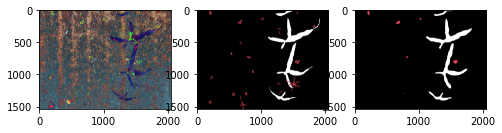

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()
image, target = next(iterator)

image = image[0]*255
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

print(out_sigmoid.shape)
print(target.shape)

predicted_class = predicted_class[0, ...]

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
target_img[np.where(target == 1)] = [255,255,255]
target_img[np.where(target == 2)] = [216,67,82]

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
prediction_img[np.where(predicted_class == 1)] = [255,255,255]
prediction_img[np.where(predicted_class == 2)] = [216,67,82]

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

print(prediction_img.shape)

fig.canvas.draw()
time.sleep(1)

In [ ]:
predicted_class.shape

TensorShape([1536, 2048])

(1227, 819)
(800, 1216)
<dtype: 'int64'>
(800, 1216, 3)
(1227, 819)


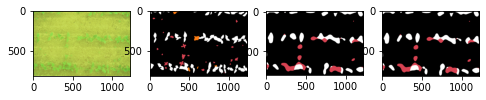

In [ ]:
from skimage import transform
fig, ax = plt.subplots(1, 4, figsize=(8, 8))
fig.show()
image = Image.open('/content/Development_Dataset/Training/Roseau/Haricot/Images/Roseau_haricot_0078_false.png')
target = Image.open('/content/Development_Dataset/Training/Roseau/Haricot/Masks/Roseau_haricot_0078_false.png')

#image = Image.open('/content/Development_Dataset/Training/Bipbip/Mais/Images/Bipbip_mais_im_07991.jpg')
#target = Image.open('/content/Development_Dataset/Training/Bipbip/Mais/Masks/Bipbip_mais_im_07991.png')

#image = image[0]*255
#target = target[0, ..., 0]
image_size = image.size
#image = image.resize((img_w, img_h))
img_array = np.array(image)
img_array = np.expand_dims(img_array, 0)

img_array_vgg = tf.keras.applications.vgg16.preprocess_input(img_array)
out_sigmoid = model.predict(x=img_array_vgg)

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

predicted_class = predicted_class[0, ...]

print(target.size)
print(predicted_class.shape)
print(predicted_class.dtype)

prediction_img = np.zeros([predicted_class.shape[0], predicted_class.shape[1], 3])

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
prediction_img[np.where(predicted_class == 1)] = [255,255,255]
prediction_img[np.where(predicted_class == 2)] = [216,67,82]

print(prediction_img.shape)
print(image_size)
#prediction_img = np.array(Image.fromarray(prediction_img).resize((image_size[0],image_size[1]), Image.NEAREST))
scaled_prediction_img = skimage.transform.resize(prediction_img, (image_size[1],image_size[0]), order=0)

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target))
ax[2].imshow(np.uint8(prediction_img))
ax[3].imshow(np.uint8(scaled_prediction_img))

fig.canvas.draw()
time.sleep(1)

# Submission

In [ ]:
def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
submission_dict = {}

In [ ]:
def prediction_for_team_crop(team,crop):
  folder = os.path.join('Development_Dataset/Test_Dev',team,crop,'Images')
  image_filenames = next(os.walk(folder))[2]

  for image_name in image_filenames:

    img = Image.open(os.path.join(folder,image_name)).convert('RGB')
    image_size = img.size
    #img = img.resize((img_w, img_h))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, 0)
    img_array_vgg = tf.keras.applications.vgg16.preprocess_input(img_array)
    out_sigmoid = model.predict(x=img_array_vgg)

    # Get predicted class as the index corresponding to the maximum value in the vector probability
    # predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
    # predicted_class = predicted_class[0, ..., 0]
    predicted_class = tf.argmax(out_sigmoid, -1)

    predicted_class = predicted_class[0, ...]

    #The following seems weird but otherwise it doesn't work
    #prediction_img = np.zeros([image_size[1], image_size[0], 3])
    print(predicted_class.shape)
    prediction_img = np.zeros([predicted_class.shape[0], predicted_class.shape[1], 3])
    prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
    prediction_img[np.where(predicted_class == 1)] = [255,255,255]
    prediction_img[np.where(predicted_class == 2)] = [216,67,82]

    #scale the output mask. order=0 mean nearest-neighbour, foundamental to keep integer correct values
    prediction_img = skimage.transform.resize(prediction_img, (image_size[1],image_size[0]), order=0)

    or_mask_arr = np.array(prediction_img)

    mask_arr = np.zeros(or_mask_arr.shape[:2], dtype=or_mask_arr.dtype)

    mask_arr[np.where(np.all(or_mask_arr == [216, 124, 18], axis=-1))] = 0
    mask_arr[np.where(np.all(or_mask_arr == [255, 255, 255], axis=-1))] = 1
    mask_arr[np.where(np.all(or_mask_arr == [216, 67, 82], axis=-1))] = 2
    
    image_name = image_name[:-4]
    submission_dict[image_name] = {}
    submission_dict[image_name]['shape'] = mask_arr.shape
    submission_dict[image_name]['team'] = team
    submission_dict[image_name]['crop'] = crop
    submission_dict[image_name]['segmentation'] = {}

    # RLE encoding
    # crop
    rle_encoded_crop = rle_encode(mask_arr == 1)
    # weed
    rle_encoded_weed = rle_encode(mask_arr == 2)

    submission_dict[image_name]['segmentation']['crop'] = rle_encoded_crop
    submission_dict[image_name]['segmentation']['weed'] = rle_encoded_weed

In [ ]:
prediction_for_team_crop('Bipbip','Haricot')
prediction_for_team_crop('Bipbip','Mais')
prediction_for_team_crop('Pead','Haricot')
prediction_for_team_crop('Pead','Mais')
prediction_for_team_crop('Roseau','Haricot')
prediction_for_team_crop('Roseau','Mais')
prediction_for_team_crop('Weedelec','Haricot')
prediction_for_team_crop('Weedelec','Mais')

(1536, 2048)
(1536, 2048)
(1536, 2048)
(1536, 2048)
(1536, 2048)
(1536, 2048)
(1536, 2048)
(1536, 2048)
(1536, 2048)
(1536, 2048)
(1536, 2048)
(1536, 2048)
(1536, 2048)
(1536, 2048)
(1536, 2048)
(1536, 2048)
(1536, 2048)
(1536, 2048)
(1536, 2048)
(1536, 2048)
(1536, 2048)
(1536, 2048)
(1536, 2048)
(1536, 2048)
(1536, 2048)
(1536, 2048)
(1536, 2048)
(1536, 2048)
(1536, 2048)
(1536, 2048)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(2464, 3264)
(800, 1216)
(800, 1216)
(800, 1216)
(800, 1216)
(800, 1216)
(800, 1216)
(800, 1216)
(800, 1216)
(800, 1216)
(800, 1216)
(800, 1216)
(800, 1216)
(800, 1216)
(800, 1216)
(800, 1216)
(800, 1216)
(800, 1216)
(800, 1216)
(800

In [ ]:
submission_dict

{'Bipbip_haricot_im_00211.jpg': {'crop': 'Haricot',
  'segmentation': {'crop': '824151 1 826194 11 828240 15 830287 18 832334 20 834380 23 836427 25 838474 27 840522 27 842569 29 844616 30 846663 32 848711 32 850255 8 850758 34 852301 12 852805 35 854347 16 854852 37 856394 18 856900 37 858440 21 858947 38 860487 22 860995 39 862534 24 863042 40 864582 25 865089 41 865544 10 866629 26 867137 41 867588 15 868676 28 869184 43 869633 20 870723 29 871231 44 871677 24 872770 31 873279 44 873721 29 874817 32 875326 45 875765 33 876864 33 877374 45 877807 40 878912 34 879421 46 879848 47 880959 35 881468 48 881851 13 881889 54 882326 8 883006 36 883516 48 883893 28 883930 61 884372 12 885053 38 885563 49 885937 102 886419 15 887101 38 887610 50 887982 105 888465 18 889148 39 889657 51 890027 108 890513 19 891195 40 891705 51 892073 110 892560 21 893242 42 893752 52 894119 112 894607 23 895289 43 895799 53 896165 114 896654 24 897336 44 897846 54 898212 115 898702 25 899383 45 899893 55 900258

In [ ]:
# Finally, save the results into the submission.json file
with open('submission.json', 'w') as f:
    json.dump(submission_dict, f)

In [ ]:
submission_dict['Pead_haricot_00463_i750']

{'crop': 'Haricot',
 'segmentation': {'crop': '4903 26 8184 23 11465 18 14748 11 18030 6 21313 1 24592 3 27869 9 31147 14 34426 18 37705 21 40984 24 44263 27 47542 30 50821 33 54101 35 57380 37 60659 41 63939 43 67218 47 70498 49 73777 53 77057 56 80337 59 83616 63 86896 67 90175 71 93455 74 96735 90 100014 94 103294 96 106574 98 109854 99 113133 102 116098 1 116413 103 119378 1 119693 105 122658 2 122973 106 125938 2 126253 107 129218 2 129532 109 132497 5 132812 110 135777 6 136092 111 139057 7 139372 111 142337 7 142652 112 145617 8 145932 112 148897 8 149212 112 152177 8 152492 111 155457 8 155771 104 158737 9 159051 98 162017 9 162332 93 165297 9 165612 90 168577 9 168892 87 171858 8 172172 85 175138 9 175452 82 178418 9 178733 79 181698 9 182013 77 184978 9 185293 75 188259 8 188574 72 191539 8 191855 69 194819 8 195136 54 198099 9 198417 47 201380 8 201698 42 204660 8 204980 35 207941 7 208262 29 211221 7 211544 22 214502 6 214829 10 217782 6 221063 5 224343 6 227624 5 230906 3 